# Model Performance Analysis

In [84]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import glob
import os
import json
import seaborn as sns

## Load Rollouts from json

In [85]:
rollout_path = "../assets/rollouts/"
rollout_files = glob.glob(os.path.join(rollout_path, "rollout_results_*.json"))

# Load all rollout files
results = {}
for file in rollout_files:
    with open(file, "r") as f:
        # Get the filename without the path and extension e.g "merged_task_1_lora"
        filename = os.path.basename(file)
        filename = filename.split(".")[0]
        filename = "_".join(filename.split("_")[2:])
        # Load the json file
        rollout = json.load(f)
        results[filename] = rollout

print(sorted(results.keys()))


['merged30k_task1_fpft', 'merged30k_task1_lora', 'merged30k_task2_fpft', 'merged30k_task2_lora', 'merged30k_task3_fpft', 'merged30k_task3_lora', 'merged30k_task4_fpft', 'merged30k_task4_lora', 'merged60k_task1_fpft', 'merged60k_task1_lora', 'merged60k_task2_fpft', 'merged60k_task2_lora', 'merged60k_task3_fpft', 'merged60k_task3_lora', 'merged60k_task4_fpft', 'merged60k_task4_lora', 'task1_fpft', 'task1_lora', 'task2_fpft', 'task2_lora', 'task3_fpft', 'task3_lora', 'task4_fpft', 'task4_lora']


## Combine all results into a single DataFrame

----

In [86]:
# Create a DataFrame with all the results (no averaging)
df = pd.DataFrame(columns=["merged", "task", "lora", "success", "task_progress", "grad_steps", "duration"])
for filename, rollout in results.items():
    # Split filename into merged (bool), task (int), lora (bool)
    merged = "merged" in filename
    if merged:
        task = int(filename.split("_")[1][-1])
    else:
        task = int(filename.split("_")[0][-1])
    lora = "lora" in filename
    if "30k" in filename:
        grad_steps = 30_000
    elif "60k" in filename:
        grad_steps = 60_000
    else:
        grad_steps = 20_000

    # Create a temp DataFrame from the rollout
    temp = pd.DataFrame(rollout)
    # Recalculate the score
    for i in range(len(temp)):
        temp.loc[i, "score"] = temp.loc[i, "steps_completed"] / temp.loc[i, "total_steps"]
    # Insert the results into the main DataFrame
    for i in range(len(temp)):
        df.loc[f"{filename}_{i}"] = [merged, task, lora, temp.loc[i, "success"], temp.loc[i, "score"], grad_steps, temp.loc[i, "duration"]]

df

,merged,task,lora,success,task_progress,grad_steps,duration
merged60k_task4_fpft_0,True,4,False,True,1.000000,60000,22.372235
merged60k_task4_fpft_1,True,4,False,True,1.000000,60000,27.516229
merged60k_task4_fpft_2,True,4,False,True,1.000000,60000,34.960509
merged60k_task4_fpft_3,True,4,False,False,0.000000,60000,53.556957
merged60k_task4_fpft_4,True,4,False,True,1.000000,60000,27.233041
...,...,...,...,...,...,...,...
merged30k_task1_fpft_15,True,1,False,False,0.666667,30000,18.347080
merged30k_task1_fpft_16,True,1,False,False,0.666667,30000,18.740873
merged30k_task1_fpft_17,True,1,False,False,0.000000,30000,49.248827
merged30k_task1_fpft_18,True,1,False,True,1.000000,30000,25.648589


In [87]:
# Create a DataFrame with the averaged results per evaluation run

df_avg = pd.DataFrame(columns=["merged", "task", "lora", "success_rate", "avg_task_progress", "grad_steps", "avg_duration"])
for filename, rollout in results.items():
    # Split filename into merged (bool), task (int), lora (bool)
    merged = "merged" in filename
    if merged:
        task = int(filename.split("_")[1][-1])
    else:
        task = int(filename.split("_")[0][-1])
    lora = "lora" in filename
    if "30k" in filename:
        grad_steps = 30_000
    elif "60k" in filename:
        grad_steps = 60_000
    else:
        grad_steps = 20_000

    # Create a temp DataFrame from the rollout
    temp = pd.DataFrame(rollout)
    # Recalculate the score
    for i in range(len(temp)):
        temp.loc[i, "score"] = temp.loc[i, "steps_completed"] / temp.loc[i, "total_steps"]
    # Calculate the success rate
    success_rate = temp["success"].mean()
    # Calculate the avg task progress
    avg_task_progress = temp["score"].mean()
    avg_duration = temp["duration"].mean()
    
    # Add the results to the main DataFrame
    df_avg.loc[filename] = [merged, task, lora, success_rate, avg_task_progress, grad_steps, avg_duration]

df_avg = df_avg.sort_values(by=["task", "avg_task_progress"], ascending=False)
df_avg

,merged,task,lora,success_rate,avg_task_progress,grad_steps,avg_duration
merged30k_task4_fpft,True,4,False,0.80,0.933333,30000,27.103511
task4_lora,False,4,True,0.80,0.900000,20000,23.301481
merged60k_task4_fpft,True,4,False,0.80,0.866667,60000,28.561584
task4_fpft,False,4,False,0.70,0.866667,20000,24.787649
merged30k_task4_lora,True,4,True,0.55,0.750000,30000,32.522494
merged60k_task4_lora,True,4,True,0.50,0.700000,60000,25.884097
merged60k_task3_fpft,True,3,False,0.90,0.925000,60000,20.925174
task3_fpft,False,3,False,0.90,0.925000,20000,22.307488
merged30k_task3_lora,True,3,True,0.85,0.850000,30000,27.455724
task3_lora,False,3,True,0.85,0.850000,20000,21.408226


*For the merged models, 60k grad_steps is the best for full-fine tuning and 30k grad_steps is the best for LoRA.*

*-> Remove the other entries for now.*

In [88]:
filter = (df["merged"] == False) | ((df["merged"] == True) & (((df["lora"] == False) & (df["grad_steps"] == 60_000)) | ((df["lora"] == True) & (df["grad_steps"] == 30_000))))
df = df[filter].copy()


filter = (df_avg["merged"] == False) | ((df_avg["merged"] == True) & (((df_avg["lora"] == False) & (df_avg["grad_steps"] == 60_000)) | ((df_avg["lora"] == True) & (df_avg["grad_steps"] == 30_000))))
df_avg = df_avg[filter].copy()
df_avg


,merged,task,lora,success_rate,avg_task_progress,grad_steps,avg_duration
task4_lora,False,4,True,0.80,0.900000,20000,23.301481
merged60k_task4_fpft,True,4,False,0.80,0.866667,60000,28.561584
task4_fpft,False,4,False,0.70,0.866667,20000,24.787649
merged30k_task4_lora,True,4,True,0.55,0.750000,30000,32.522494
merged60k_task3_fpft,True,3,False,0.90,0.925000,60000,20.925174
task3_fpft,False,3,False,0.90,0.925000,20000,22.307488
merged30k_task3_lora,True,3,True,0.85,0.850000,30000,27.455724
task3_lora,False,3,True,0.85,0.850000,20000,21.408226
merged60k_task2_fpft,True,2,False,0.25,0.687500,60000,26.827389
task2_fpft,False,2,False,0.35,0.675000,20000,25.961369


## Analyse specific Subsets

### Group by grad_steps

In [89]:
avg_success_rate = df.groupby("grad_steps").success.mean()
print(f"Avg Success Rate for 20k Grad Steps: {avg_success_rate[20000]:.2f}")
print(f"Avg Success Rate for 30k Grad Steps: {avg_success_rate[30000]:.2f}")
print(f"Avg Success Rate for 60k Grad Steps: {avg_success_rate[60000]:.2f}")

avg_task_progress = df.groupby("grad_steps").task_progress.mean()
print()
print(f"Avg Task Progress for 20k Grad Steps: {avg_task_progress[20000]:.2f}")
print(f"Avg Task Progress for 30k Grad Steps: {avg_task_progress[30000]:.2f}")
print(f"Avg Task Progress for 60k Grad Steps: {avg_task_progress[60000]:.2f}")


Avg Success Rate for 20k Grad Steps: 0.61
Avg Success Rate for 30k Grad Steps: 0.53
Avg Success Rate for 60k Grad Steps: 0.65

Avg Task Progress for 20k Grad Steps: 0.82
Avg Task Progress for 30k Grad Steps: 0.73
Avg Task Progress for 60k Grad Steps: 0.84


### Group by merged

In [90]:
avg_success_rate = df.groupby("merged").success.mean()
print(f"Avg Success Rate for Merged Models: {avg_success_rate[True]:.2f}")
print(f"Avg Success Rate for Dedicated Models: {avg_success_rate[False]:.2f}")

avg_task_progress = df.groupby("merged").task_progress.mean()
print()
print(f"Avg Task Progress for Merged Models: {avg_task_progress[True]:.2f}")
print(f"Avg Task Progress for Dedicated Models: {avg_task_progress[False]:.2f}")


Avg Success Rate for Merged Models: 0.59
Avg Success Rate for Dedicated Models: 0.61

Avg Task Progress for Merged Models: 0.79
Avg Task Progress for Dedicated Models: 0.82


### Group by LoRA

In [91]:
avg_success_rate = df.groupby("lora").success.mean()
print(f"Avg Success Rate for LoRA Models: {avg_success_rate[True]:.2f}")
print(f"Avg Success Rate for Non-LoRA Models: {avg_success_rate[False]:.2f}")

avg_task_progress = df.groupby("lora").task_progress.mean()
print()
print(f"Avg Task Progress for LoRA Models: {avg_task_progress[True]:.2f}")
print(f"Avg Task Progress for Non-LoRA Models: {avg_task_progress[False]:.2f}")

Avg Success Rate for LoRA Models: 0.53
Avg Success Rate for Non-LoRA Models: 0.66

Avg Task Progress for LoRA Models: 0.76
Avg Task Progress for Non-LoRA Models: 0.84


### Group by task

In [92]:
avg_success_rate = df.groupby("task").success.mean()
for i in range(1, len(avg_success_rate) + 1):
    print(f"Avg Success Rate for Task {i}: {avg_success_rate[i]:.2f}")

avg_task_progress = df.groupby("task").task_progress.mean()
print()
for i in range(1, len(avg_task_progress) + 1):
    print(f"Avg Task Progress for Task {i}: {avg_task_progress[i]:.2f}")


Avg Success Rate for Task 1: 0.59
Avg Success Rate for Task 2: 0.21
Avg Success Rate for Task 3: 0.88
Avg Success Rate for Task 4: 0.71

Avg Task Progress for Task 1: 0.85
Avg Task Progress for Task 2: 0.62
Avg Task Progress for Task 3: 0.89
Avg Task Progress for Task 4: 0.85


### Group by LoRA and merged

In [93]:
avg_success_rate = df.groupby(["lora", "merged"]).success.mean()
print(avg_success_rate)

avg_task_progress = df.groupby(["lora", "merged"]).task_progress.mean()
print()
print(avg_task_progress)


lora   merged
False  False     0.6750
       True      0.6500
True   False     0.5375
       True      0.5250
Name: success, dtype: float64

lora   merged
False  False     0.845833
       True      0.840625
True   False     0.785417
       True      0.734375
Name: task_progress, dtype: float64


### Group by task and merged

In [94]:
avg_success_rate = df.groupby(["task", "merged"]).success.mean()
print(avg_success_rate)

avg_task_progress = df.groupby(["task", "merged"]).task_progress.mean()
print()
print(avg_task_progress)

task  merged
1     False     0.600
      True      0.575
2     False     0.200
      True      0.225
3     False     0.875
      True      0.875
4     False     0.750
      True      0.675
Name: success, dtype: float64

task  merged
1     False     0.866667
      True      0.841667
2     False     0.625000
      True      0.612500
3     False     0.887500
      True      0.887500
4     False     0.883333
      True      0.808333
Name: task_progress, dtype: float64


## Tables

---

In [95]:
# Define the task mapping for the table
task_names = {
    1: "1. Bolt Insertion (Easy)",
    2: "2. Bolt Insertion (Hard)",
    3: "3. Pick \& Place",
    4: "4. Bearing Insertion"
}

# Create a summary table
table_data = []

for task_id in range(1, 5):
    row = {"Task": task_names[task_id]}
    for merged in [False, True]:
        for lora in [False, True]:
            # Filter for specific subset
            subset = df[(df["task"] == task_id) & (df["merged"] == merged) & (df["lora"] == lora)]
            
            # Calculate metrics
            mean_val = subset["task_progress"].mean()
            std_val = subset["task_progress"].std()
            
            # Labeling for the keys
            type_str = "Merged" if merged else "Dedicated"
            strat_str = "LoRA" if lora else "FFT"
            
            row[f"{type_str}_{strat_str}_Mean"] = mean_val
            row[f"{type_str}_{strat_str}_Std"] = std_val
            
    table_data.append(row)

# Add Overall Average row
overall_row = {"Task": "Overall Average"}
for merged in [False, True]:
    for lora in [False, True]:
        subset = df[(df["merged"] == merged) & (df["lora"] == lora)]
        overall_row[f"Merged_{'LoRA' if lora else 'FFT'}_Mean" if merged else f"Dedicated_{'LoRA' if lora else 'FFT'}_Mean"] = subset["task_progress"].mean()
        overall_row[f"Merged_{'LoRA' if lora else 'FFT'}_Std" if merged else f"Dedicated_{'LoRA' if lora else 'FFT'}_Std"] = subset["task_progress"].std()

table_data.append(overall_row)

# Create DataFrame for display
results_table = pd.DataFrame(table_data)

# Reorder columns to match the LaTeX table structure
columns_order = [
    "Task",
    "Dedicated_FFT_Mean", "Dedicated_FFT_Std",
    "Dedicated_LoRA_Mean", "Dedicated_LoRA_Std",
    "Merged_FFT_Mean", "Merged_FFT_Std",
    "Merged_LoRA_Mean", "Merged_LoRA_Std"
]
results_table = results_table[columns_order]

# Display formatted results
print("Values for LaTeX Table (Average Task Progress):")
print("-" * 100)
for _, r in results_table.iterrows():
    print(f"{r['Task']:<25} | "
          f"{r['Dedicated_FFT_Mean']:.2f} ({r['Dedicated_FFT_Std']:.2f}) | "
          f"{r['Dedicated_LoRA_Mean']:.2f} ({r['Dedicated_LoRA_Std']:.2f}) | "
          f"{r['Merged_FFT_Mean']:.2f} ({r['Merged_FFT_Std']:.2f}) | "
          f"{r['Merged_LoRA_Mean']:.2f} ({r['Merged_LoRA_Std']:.2f})")

# # Optional: Generate LaTeX rows directly
print("\nLaTeX Rows:")
for _, r in results_table.iterrows():
    line = f"{r['Task']} & "
    line += " & ".join([f"{r[c]:.2f}" for c in columns_order[1:]])
    line += " \\\\"
    print(line)

Values for LaTeX Table (Average Task Progress):
----------------------------------------------------------------------------------------------------
1. Bolt Insertion (Easy)  | 0.92 (0.15) | 0.82 (0.17) | 0.88 (0.16) | 0.80 (0.25)
2. Bolt Insertion (Hard)  | 0.68 (0.29) | 0.57 (0.20) | 0.69 (0.21) | 0.54 (0.28)
3. Pick \& Place          | 0.93 (0.24) | 0.85 (0.37) | 0.93 (0.24) | 0.85 (0.37)
4. Bearing Insertion      | 0.87 (0.25) | 0.90 (0.24) | 0.87 (0.31) | 0.75 (0.36)
Overall Average           | 0.85 (0.26) | 0.79 (0.28) | 0.84 (0.25) | 0.73 (0.33)

LaTeX Rows:
1. Bolt Insertion (Easy) & 0.92 & 0.15 & 0.82 & 0.17 & 0.88 & 0.16 & 0.80 & 0.25 \\
2. Bolt Insertion (Hard) & 0.68 & 0.29 & 0.57 & 0.20 & 0.69 & 0.21 & 0.54 & 0.28 \\
3. Pick \& Place & 0.93 & 0.24 & 0.85 & 0.37 & 0.93 & 0.24 & 0.85 & 0.37 \\
4. Bearing Insertion & 0.87 & 0.25 & 0.90 & 0.24 & 0.87 & 0.31 & 0.75 & 0.36 \\
Overall Average & 0.85 & 0.26 & 0.79 & 0.28 & 0.84 & 0.25 & 0.73 & 0.33 \\


<>:5: SyntaxWarning:

invalid escape sequence '\&'

<>:5: SyntaxWarning:

invalid escape sequence '\&'

/var/folders/7c/7m_qlbms5k1cv6f_63f4cs4m0000gn/T/ipykernel_11422/3321827530.py:5: SyntaxWarning:

invalid escape sequence '\&'



In [96]:
# Filter for successful episodes only for TTC analysis
df_success = df[df["success"] == True].copy()

# Define the task mapping for the table
task_names = {
    1: "1. Bolt Insertion (Easy)",
    2: "2. Bolt Insertion (Hard)",
    3: "3. Pick & Place",
    4: "4. Bearing Insertion"
}

# Create a summary table for TTC
table_data_ttc = []

for task_id in range(1, 5):
    row = {"Task": task_names[task_id]}
    for merged in [False, True]:
        for lora in [False, True]:
            # Filter for specific subset of successful runs
            subset = df_success[(df_success["task"] == task_id) & 
                                (df_success["merged"] == merged) & 
                                (df_success["lora"] == lora)]
            
            # Calculate metrics (duration in seconds)
            mean_val = subset["duration"].mean()
            std_val = subset["duration"].std()
            
            type_str = "Merged" if merged else "Dedicated"
            strat_str = "LoRA" if lora else "FFT"
            
            row[f"{type_str}_{strat_str}_Mean"] = mean_val
            row[f"{type_str}_{strat_str}_Std"] = std_val
            
    table_data_ttc.append(row)

# Add Overall Average row (across all tasks, successful only)
overall_row_ttc = {"Task": "Overall Average"}
for merged in [False, True]:
    for lora in [False, True]:
        subset = df_success[(df_success["merged"] == merged) & (df_success["lora"] == lora)]
        
        type_str = "Merged" if merged else "Dedicated"
        strat_str = "LoRA" if lora else "FFT"
        
        overall_row_ttc[f"{type_str}_{strat_str}_Mean"] = subset["duration"].mean()
        overall_row_ttc[f"{type_str}_{strat_str}_Std"] = subset["duration"].std()

table_data_ttc.append(overall_row_ttc)

# Create DataFrame for display
ttc_results_table = pd.DataFrame(table_data_ttc)

# Reorder columns to match the LaTeX table structure
columns_order = [
    "Task",
    "Dedicated_FFT_Mean", "Dedicated_FFT_Std",
    "Dedicated_LoRA_Mean", "Dedicated_LoRA_Std",
    "Merged_FFT_Mean", "Merged_FFT_Std",
    "Merged_LoRA_Mean", "Merged_LoRA_Std"
]
ttc_results_table = ttc_results_table[columns_order]

# Display formatted results
print("Values for LaTeX Table (Time to Completion - SUCCESSFUL ONLY):")
print("-" * 110)
for _, r in ttc_results_table.iterrows():
    # Handle NaN if a configuration had 0 successes
    vals = []
    for col in columns_order[1:]:
        val = r[col]
        vals.append(f"{val:.2f}" if pd.notnull(val) else "N/A")
    
    print(f"{r['Task']:<25} | "
          f"{vals[0]} ({vals[1]}) | "
          f"{vals[2]} ({vals[3]}) | "
          f"{vals[4]} ({vals[5]}) | "
          f"{vals[6]} ({vals[7]})")

# Generate LaTeX rows directly
print("\nLaTeX Rows:")
for _, r in ttc_results_table.iterrows():
    row_vals = []
    for col in columns_order[1:]:
        val = r[col]
        row_vals.append(f"{val:.2f}" if pd.notnull(val) else "-")
    
    line = f"{r['Task']} & " + " & ".join(row_vals) + " \\\\"
    print(line)

Values for LaTeX Table (Time to Completion - SUCCESSFUL ONLY):
--------------------------------------------------------------------------------------------------------------
1. Bolt Insertion (Easy)  | 18.63 (1.91) | 19.70 (2.00) | 19.64 (1.61) | 20.24 (3.36)
2. Bolt Insertion (Hard)  | 32.45 (9.22) | 26.16 (N/A) | 33.55 (4.52) | 31.96 (7.42)
3. Pick & Place           | 18.27 (10.10) | 16.64 (9.17) | 16.87 (8.29) | 20.78 (10.43)
4. Bearing Insertion      | 22.32 (3.07) | 22.65 (5.47) | 26.18 (4.42) | 28.98 (9.31)
Overall Average           | 21.26 (8.21) | 19.74 (7.18) | 22.03 (7.75) | 23.86 (9.52)

LaTeX Rows:
1. Bolt Insertion (Easy) & 18.63 & 1.91 & 19.70 & 2.00 & 19.64 & 1.61 & 20.24 & 3.36 \\
2. Bolt Insertion (Hard) & 32.45 & 9.22 & 26.16 & - & 33.55 & 4.52 & 31.96 & 7.42 \\
3. Pick & Place & 18.27 & 10.10 & 16.64 & 9.17 & 16.87 & 8.29 & 20.78 & 10.43 \\
4. Bearing Insertion & 22.32 & 3.07 & 22.65 & 5.47 & 26.18 & 4.42 & 28.98 & 9.31 \\
Overall Average & 21.26 & 8.21 & 19.74 & 7.1

## Plots

---

We are trying to answer the following questions:

1. How much better is full fine-tuning than LoRA?
2. How does the difference change over the different tasks?


Question 1

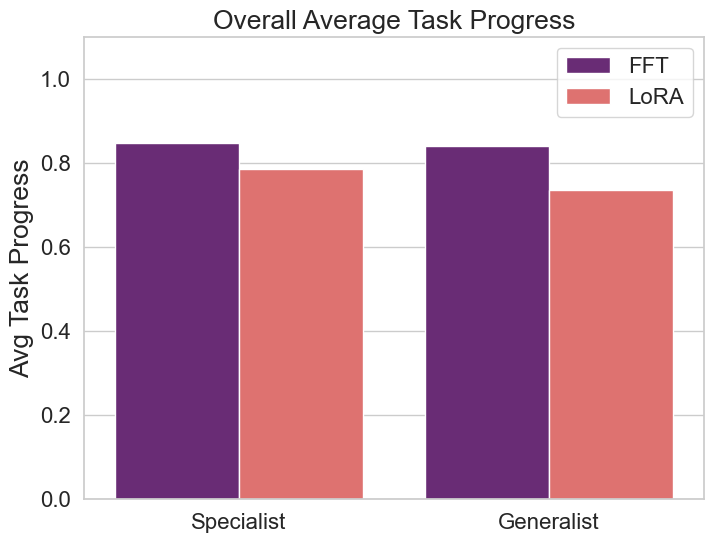

In [97]:
font_size = 16
font_size_large = 19

plt.figure(figsize=(8, 6))
# We group by the broad categories for a high-level view
summary_df = df.groupby(['lora', 'merged'])['task_progress'].mean().reset_index()
summary_df['Strategy'] = summary_df.apply(lambda x: 
    f"{'LoRA' if x['lora'] else 'FFT'}", axis=1)
summary_df['Type'] = summary_df.apply(lambda x: 
    f"{'Generalist' if x['merged'] else 'Specialist'}", axis=1)

sns.barplot(data=summary_df, x="Type", y="task_progress", hue="Strategy", palette="magma")
plt.title("Overall Average Task Progress", fontsize=font_size_large)
plt.xlabel("") # Remove x label
plt.ylabel("Avg Task Progress", fontsize=font_size_large)
plt.ylim(0, 1.1)
plt.xlabel("", fontsize=font_size_large)
plt.xticks(fontsize=font_size)
plt.yticks(fontsize=font_size)
plt.legend(fontsize=font_size)
plt.show()

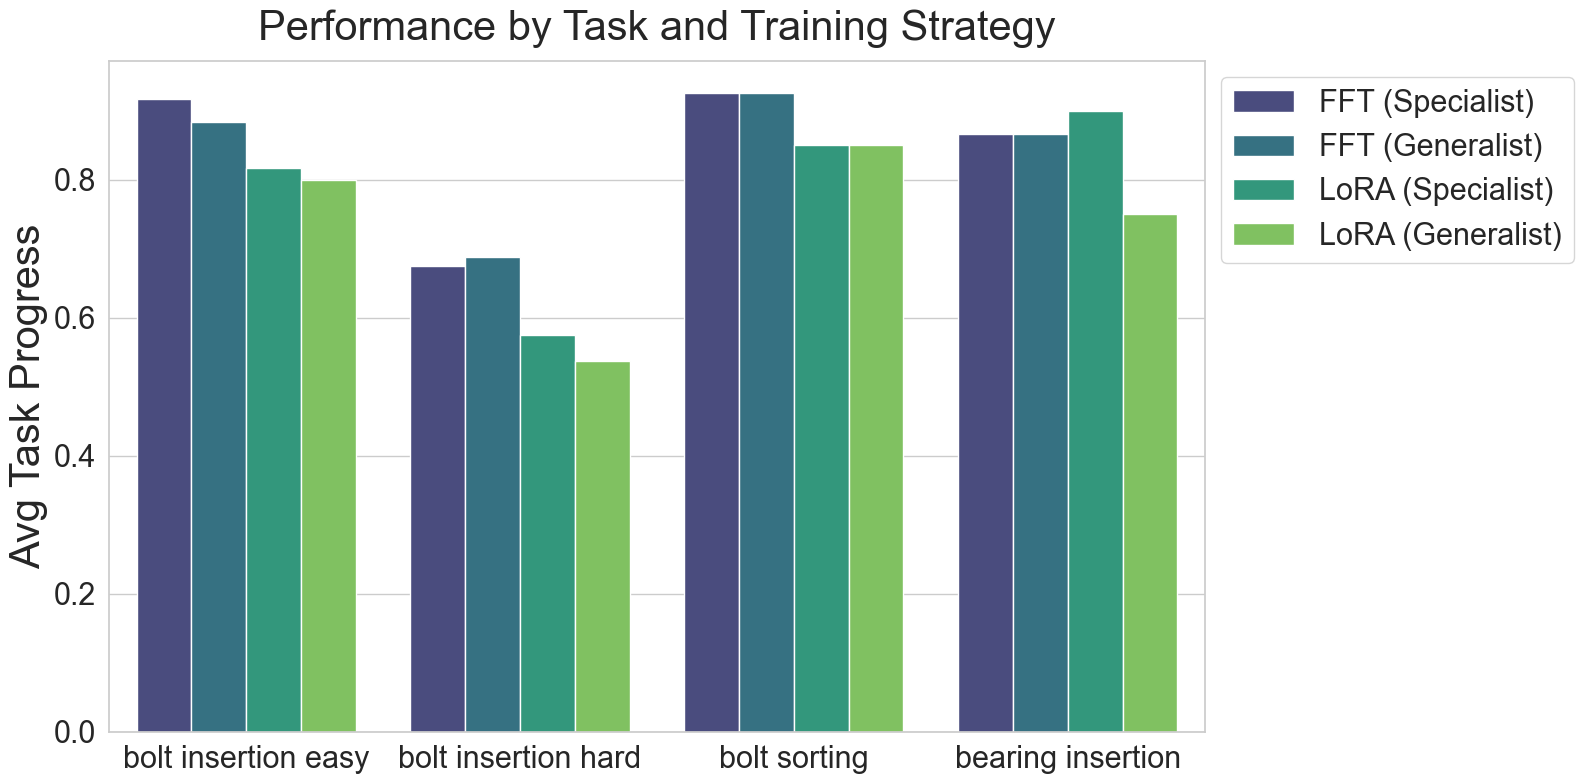

In [98]:
sns.set_theme(style="whitegrid")
plt.rcParams.update({'font.size': 12})
font_size = 22
font_size_large = 30

plt.figure(figsize=(16, 8))
# Create a custom 'Method' column for cleaner legends
df['Method'] = df.apply(lambda x: 
    f"{'LoRA' if x['lora'] else 'FFT'} ({'Generalist' if x['merged'] else 'Specialist'})", axis=1)

task_stings = {
    1: "bolt insertion easy",
    2: "bolt insertion hard",
    3: "bolt sorting",
    4: "bearing insertion"
}

method_order = [
    "FFT (Specialist)",
    "FFT (Generalist)",
    "LoRA (Specialist)",
    "LoRA (Generalist)",
]

# optional: also fix x-axis order'
task_order = [
    "bolt insertion easy",
    "bolt insertion hard",
    "bolt sorting",
    "bearing insertion",
]

df['task_str'] = df['task'].apply(lambda x: task_stings[x])

sns.barplot(
    data=df.sort_values(by="task"),
    x="task_str", 
    y="task_progress", 
    hue="Method",
    order=task_order,
    hue_order=method_order,
    palette="viridis",
    errorbar=None,
)

plt.title("Performance by Task and Training Strategy", fontsize=font_size_large, pad=15)
plt.ylabel("Avg Task Progress", fontsize=font_size_large)
plt.xlabel("", fontsize=font_size_large)
plt.xticks(fontsize=font_size)
plt.yticks(fontsize=font_size)
plt.legend(bbox_to_anchor=(1.001, 1), loc='upper left', fontsize=font_size)
plt.tight_layout()
plt.show()

## Plot Durations

In [99]:
# Build df with successfull episodes only
df_success_only = df.copy().loc[df["success"]]

df_success_only

,merged,task,lora,success,task_progress,grad_steps,duration,Method,task_str
merged60k_task4_fpft_0,True,4,False,True,1.0,60000,22.372235,FFT (Generalist),bearing insertion
merged60k_task4_fpft_1,True,4,False,True,1.0,60000,27.516229,FFT (Generalist),bearing insertion
merged60k_task4_fpft_2,True,4,False,True,1.0,60000,34.960509,FFT (Generalist),bearing insertion
merged60k_task4_fpft_4,True,4,False,True,1.0,60000,27.233041,FFT (Generalist),bearing insertion
merged60k_task4_fpft_5,True,4,False,True,1.0,60000,24.124242,FFT (Generalist),bearing insertion
...,...,...,...,...,...,...,...,...,...
task4_fpft_15,False,4,False,True,1.0,20000,22.677409,FFT (Specialist),bearing insertion
task4_fpft_17,False,4,False,True,1.0,20000,17.754970,FFT (Specialist),bearing insertion
task4_fpft_18,False,4,False,True,1.0,20000,21.173425,FFT (Specialist),bearing insertion
task4_fpft_19,False,4,False,True,1.0,20000,22.179110,FFT (Specialist),bearing insertion


    lora  merged   duration Strategy       Type
0  False   False  21.258826      FFT  Dedicated
1  False    True  22.033286      FFT     Merged
2   True   False  19.738034     LoRA  Dedicated
3   True    True  23.864512     LoRA     Merged


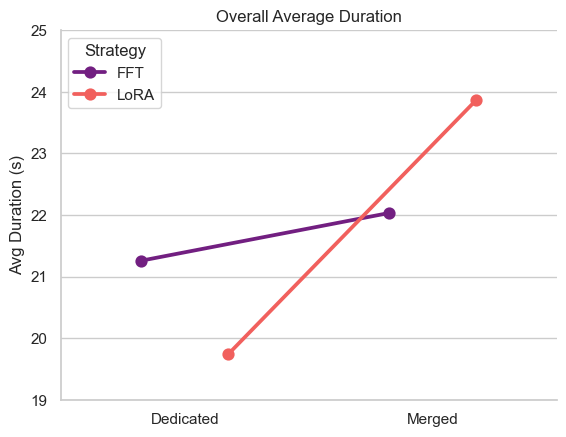

In [100]:
# We group by the broad categories for a high-level view
summary_df = df_success_only.groupby(['lora', 'merged'])['duration'].mean().reset_index()
summary_df['Strategy'] = summary_df.apply(lambda x: 
    f"{'LoRA' if x['lora'] else 'FFT'}", axis=1)
summary_df['Type'] = summary_df.apply(lambda x: 
    f"{'Merged' if x['merged'] else 'Dedicated'}", axis=1)

print(summary_df)

sns.set_theme(style="whitegrid")

ax = sns.pointplot(
    data=summary_df,
    x="Type",
    y="duration",
    hue="Strategy",
    dodge=0.35,
    errorbar=("ci", 95),  
    capsize=0.15,
    palette="magma",
)
# Set y limit 
ax.set_ylim(19, 25)
ax.set(title="Overall Average Duration", xlabel="", ylabel="Avg Duration (s)")
sns.despine()
plt.show()

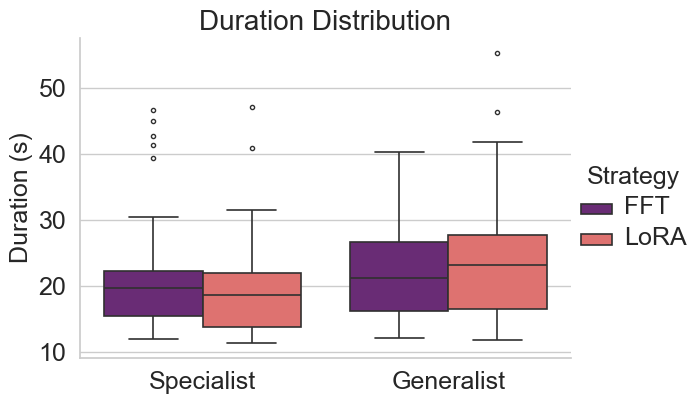

In [111]:
summary_df = df_success_only.copy()
summary_df["Strategy"] = summary_df.apply(lambda x: "LoRA" if x["lora"] else "FFT", axis=1)
summary_df["Type"] = summary_df.apply(lambda x: "Generalist" if x["merged"] else "Specialist", axis=1)

type_order = ["Specialist", "Generalist"]
strategy_order = ["FFT", "LoRA"]

font_size_title = 20
font_size_label = 18
font_size_tick = 18
font_size_legend = 18

g = sns.catplot(
    data=summary_df,
    x="Type",
    y="duration",
    hue="Strategy",
    kind="box",
    order=type_order,
    hue_order=strategy_order,
    palette="magma",
    height=4.2,
    aspect=1.2,
    linewidth=1.2,
    fliersize=3,
)

g.ax.set_title("Duration Distribution", fontsize=font_size_title)
g.ax.set_xlabel("", fontsize=font_size_label)
g.ax.set_ylabel("Duration (s)", fontsize=font_size_label)
g.ax.tick_params(axis='both', labelsize=font_size_tick)
g._legend.set_title("Strategy")
g._legend.get_title().set_fontsize(font_size_legend)
for text in g._legend.get_texts():
    text.set_fontsize(font_size_legend)
g._legend.set_bbox_to_anchor((0.95, 0.6))
g._legend.set_loc("upper left")
g._legend.set_frame_on(False)

sns.despine(ax=g.ax)
plt.tight_layout()
plt.show()

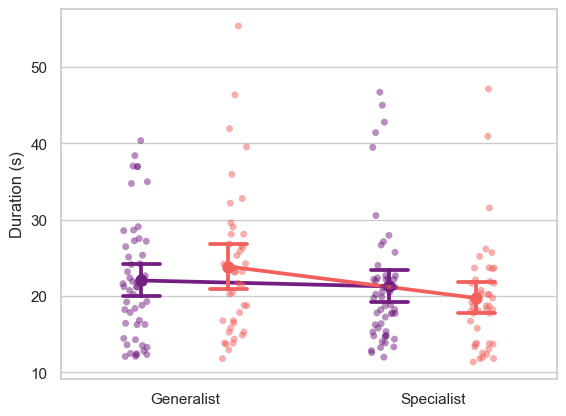

In [102]:
ax = sns.stripplot(data=summary_df, x="Type", y="duration", hue="Strategy", dodge=True, alpha=0.5, palette="magma")
sns.pointplot(data=summary_df, x="Type", y="duration", hue="Strategy", dodge=0.35, errorbar=("ci", 95), capsize=0.15, palette="magma", ax=ax)
ax.legend_.remove()  # optional cleanup; make one legend manually if you want
plt.xlabel("")
plt.ylabel("Duration (s)")
plt.show()

## Sankey Diagrams

In [103]:
import plotly.graph_objects as go

# 1. Prepare the data for Task 2
task2_df = df[df["task"] == 2].copy()
total_steps = 4
task2_df["steps_completed"] = (task2_df["task_progress"] * total_steps).round().astype(int)

# 2. Calculate counts
counts = task2_df["steps_completed"].value_counts().reindex(range(total_steps + 1), fill_value=0)

n_total = len(task2_df)
# Success path counts (flow continuing to next step)
n_passed_1 = counts[1:].sum()
n_passed_2 = counts[2:].sum()
n_passed_3 = counts[3:].sum()
n_passed_4 = counts[4:].sum() # Final SUCCESS

# Failure counts (flow dropping out at this step)
n_failed_1 = counts[0]
n_failed_2 = counts[1]
n_failed_3 = counts[2]
n_failed_4 = counts[3]

# 3. Define Nodes and Manual Positions
# We define X positions (0 to 1) for each column (step)
# We define Y positions (0 to 1) to force Success to TOP and Failures to BOTTOM
# Y is the center of the node. 
# Top aligned center = (value/total)/2
# Bottom aligned center = 1 - (value/total)/2

node_labels = [
    "",                      # 0
    "lifted the bolt",             # 1
    "approached hole",            # 2
    "inserted partially",        # 3
    "success",                  # 4
    "didn't lift the bolt",       # 5
    "didn't approach hole",      # 6
    "didn't insert partially",   # 7
    "didn't finish insertion"   # 8
]

# Calculate normalized sizes for Y positioning
def get_y_top(value, total):
    return (value / total) / 2

def get_y_bottom(value, total):
    return 1 - ((value / total) / 2)

# Node 0: Total (Column 0)
x0, y0 = 0.001, 0.5 # Centered vertically at start or top? Let's center it or top it. 
# To match 'success at top' visual, let's align Total to top too.
y0 = get_y_top(n_total, n_total) 

# Success Path Nodes (Aligned Top)
x1, y1 = 0.25, get_y_top(n_passed_1, n_total)
x2, y2 = 0.50, get_y_top(n_passed_2, n_total)
x3, y3 = 0.75, get_y_top(n_passed_3, n_total)
x4, y4 = 0.999, get_y_top(n_passed_4, n_total)

# Failure Path Nodes (Aligned Bottom)
# Note: Failure 1 happens at Step 1 column (x=0.25)
x5, y5 = 0.25, get_y_bottom(n_failed_1, n_total)
x6, y6 = 0.50, get_y_bottom(n_failed_2, n_total)
x7, y7 = 0.75, get_y_bottom(n_failed_3, n_total)
x8, y8 = 0.999, get_y_bottom(n_failed_4, n_total)

x_nodes = [x0, x1, x2, x3, x4, x5, x6, x7, x8]
y_nodes = [y0, y1, y2, y3, y4, y5, y6, y7, y8]

# 4. Links
sources = [0, 0, 1, 1, 2, 2, 3, 3]
targets = [1, 5, 2, 6, 3, 7, 4, 8]
values =  [n_passed_1, n_failed_1, n_passed_2, n_failed_2, n_passed_3, n_failed_3, n_passed_4, n_failed_4]

# 5. Styling
colors_success = ["#cbd5e1", "#93c5fd", "#86efac", "#fde047", "#4ade80"]
color_failure = "#f87171"

node_colors = [
    colors_success[0], # Total
    colors_success[1], # Step 1
    colors_success[1], # Step 2
    colors_success[1], # Step 3
    colors_success[4], # SUCCESS
    color_failure,     # Fail 1
    color_failure,     # Fail 2
    color_failure,     # Fail 3
    color_failure      # Fail 4
]

link_colors = [
    "rgba(147, 197, 253, 0.6)", # to Step 1
    "rgba(248, 113, 113, 0.6)", # to Failed 1
    "rgba(147, 197, 253, 0.6)", # to Step 2
    "rgba(248, 113, 113, 0.6)", # to Failed 2
    "rgba(147, 197, 253, 0.6)",  # to Step 3
    "rgba(248, 113, 113, 0.6)", # to Failed 3
    "rgba(74, 222, 128, 0.6)",  # to SUCCESS
    "rgba(248, 113, 113, 0.6)"  # to Failed 4
]

fig = go.Figure(data=[go.Sankey(
    arrangement = "snap", # Helps keep nodes in place if not fully constrained
    textfont = dict(size=16, family="Arial"),
    node = dict(
      pad = 20,
      thickness = 25,
      line = dict(color = "black", width = 0.5),
      label = node_labels,
      color = node_colors,
      x = x_nodes,
      y = y_nodes
    ),
    link = dict(
      source = sources,
      target = targets,
      value = values,
      color = link_colors
  ))])

fig.update_layout(
    title_text="Task 2 Failure Analysis: Bolt Insertion (Hard)",
    # make title black
    title_font_color="black",
    font_size=14,
    width=1000,
    height=600,
    plot_bgcolor='white',
    paper_bgcolor='white'
)

fig.show()